In [ ]:
!pip install copick git+https://github.com/copick/copick-utils.git git+https://github.com/copick/DeepFindET.git

In [3]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "/kaggle/working/copick.config"
output_overlay = "/kaggle/working/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    


In [ ]:
# Setup new overlay directory
import os
import shutil

# Define source and destination directories
source_dir = '/kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = '/kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")


In [5]:
from deepfindET.entry_points import step1
from deepfindET.utils import copick_tools
import matplotlib.pyplot as plt
import copick

%matplotlib inline

################## Input Parameters #################

# Config File
config = '/kaggle/working/copick.config'

# Query Tomogram
voxel_size = 10 
tomogram_algorithm = 'denoised'

# Output Name for the Segmentation Targets
out_name = 'remotetargets'
out_user_id = 'deepfindET'
out_session_id = '0'

# Read Copick Directory
copickRoot = copick.from_file(config)



In [6]:
[(obj.name, None, None, (obj.radius / voxel_size)) for obj in copickRoot.pickable_objects if obj.is_particle]

[('apo-ferritin', None, None, 6.0),
 ('beta-amylase', None, None, 6.5),
 ('beta-galactosidase', None, None, 9.0),
 ('ribosome', None, None, 15.0),
 ('thyroglobulin', None, None, 13.0),
 ('virus-like-particle', None, None, 13.5)]

In [7]:
# Query Train Protein Coordiantes and any Associated Segmentations
train_targets = {}

# Define protein targets with their respective radii
# We can Provide two forms of inputs, either 
# ('protein-name',radius) or ('protein-name', 'user-id', 'session-id', 'radius')
targets = [(obj.name, None, None, (obj.radius / voxel_size)) for obj in copickRoot.pickable_objects if obj.is_particle]

# Set run_ids to None, indicating that targets will be generated for the entire CoPick project by default.
# If specific Run-IDs were provided, this variable would contain a list of those IDs.
run_ids = None

In [8]:
# Generate train target information
for t in targets:
    obj_name, user_id, session_id, radius = t
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": radius,
        "is_particle_target": True,
    }
    train_targets[obj_name] = info


# Define segmentation target (e.g., membrane)
seg_targets = [('membrane', None, None)]

# Generate segmentation target information
for s in seg_targets:
    obj_name, user_id, session_id = s
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": None,       
        "is_particle_target": False,                 
    }
    train_targets[obj_name] = info

# Call the create_train_targets function from step1 to generate the training targets for the 3D U-Net model.
# The function will use the parameters defined in the previous cells and the following inputs:
step1.create_train_targets(
    config,              # The configuration file path specifying various settings and parameters for the project.
    train_targets,       # A dictionary containing the target information for each protein or object to be segmented.
    run_ids,             # The list of Run-IDs for which to generate targets. None means targets for the entire project.
    voxel_size,          # The voxel size to be used in the tomogram data.
    tomogram_algorithm,  # The reconstruction algorithm used for the tomograms, e.g., 'wbp' (weighted back projection).
    out_name,            # The output name for the generated segmentation targets.
    out_user_id,         # The user ID under which the output targets will be saved.
    out_session_id,      # The session ID associated with the output, typically used for tracking purposes.
)

Processing Run: TS_5_4
Annotating 140 objects ...

Processing Run: TS_69_2
Annotating 143 objects ...

Processing Run: TS_6_4
Annotating 193 objects ...

Processing Run: TS_6_6
Annotating 143 objects ...

Processing Run: TS_73_6
Annotating 217 objects ...

Processing Run: TS_86_3
Annotating 225 objects ...

Processing Run: TS_99_9
Annotating 208 objects ...



In [9]:
# Option 1: Query All RunIDs
# Retrieve all available Run-IDs from the CoPick project. This generates a list of Run-IDs by iterating over all runs in copickRoot.
run_ids = [run.name for run in copickRoot.runs]

# Option 2: Manually Specify Specific Run
# Define a specific Run-ID manually. This is useful for extracting volumes for a specific run.
runID = 'TS_6_4'

# Retrieve the specific run object from CoPick using the manually specified Run-ID.
copick_run = copickRoot.get_run(runID)

# Extract the segmentation target associated with the specified run.
# The function get_copick_segmentation retrieves the segmentation data (e.g., target volume) based on the run object,
# segmentation name, user ID, and session ID.
train_target = copick_tools.get_copick_segmentation(
    copick_run,                 # The run object obtained from CoPick for the specific Run-ID.
    segmentationName='remotetargets',  # The name of the segmentation target to retrieve.
    userID='deepfindET',        # The user ID under which the segmentation data is saved.
    sessionID='0'               # The session ID associated with the segmentation data.
)

# Retrieve the tomogram associated with the specified Run-ID from the CoPick project.
# The function get_copick_tomogram extracts the tomogram data, using the voxel size, algorithm, and Run-ID.
train_tomogram = copick_tools.get_copick_tomogram(
    copickRoot,                 # The root object for the CoPick project, containing all runs and associated data.
    voxelSize=voxel_size,       # The voxel size to be used for retrieving the tomogram.
    tomoAlgorithm='denoised',        # The reconstruction algorithm used for the tomogram, e.g., 'wbp' (weighted back projection).
    tomoID=runID                # The specific Run-ID for which the tomogram is being retrieved.
)

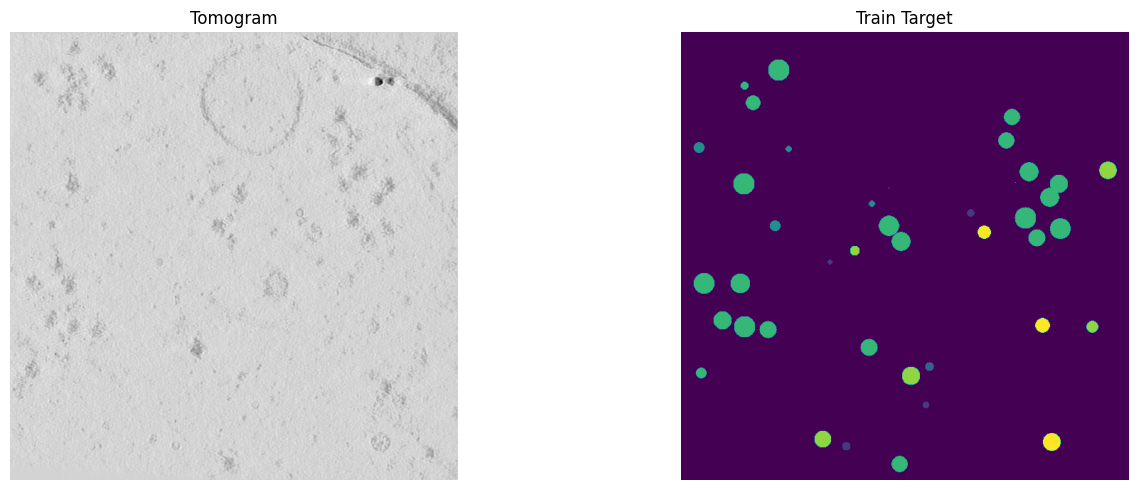

In [10]:
# Plot the images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(train_tomogram[90,],cmap='gray')
plt.axis('off')

# Original Image
plt.subplot(1, 2, 2)
plt.title('Train Target')
plt.imshow(train_target[90,])
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from deepfindET.entry_points import step2

# Specify the directory where the training results will be saved.
training_output_path = '/kaggle/working/train_results'

# Set the model architecture to Residual U-Net ('res_unet'), 
# which combines U-Net with residual connections to improve training.
model_name = 'res_unet'

# Set to None to indicate that the model will be trained from scratch 
# without using pre-trained weights.
model_pre_weights = None

# Number of classes the model will predict. 
# Here, we are working with 8 different classes (6 proteins + membrane + background).
n_class = 8

# Input dimension size of the 3D volumes in voxels. Each input is a 72x72x72 voxel cube -- (72 Å)^3.
dim_in = 72  # [voxels]


Training res_unet with Randomly Initialized Weights

Physical devices cannot be modified after being initialized
Loading Targets and Tomograms for the Following Runs: ['TS_99_9', 'TS_73_6', 'TS_6_4']


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Configuration saved to /kaggle/working/train_results/experiment_config.json

Training Parameters:  {
    "input": {
        "config_path_train": "/kaggle/working/copick.config",
        "config_path_valid": null,
        "target_name": "remotetargets",
        "target_user_id": "deepfindET",
        "target_session_id": "0"
    },
    "output": {
        "out_dir": "/kaggle/working/train_results",
        "classes": {
            "apo-ferritin": 1,
            "beta-amylase": 2,
            "beta-galactosidase": 3,
            "ribosome": 4,
            "thyroglobulin": 5,
            "virus-like-particle": 6,
            "membrane": 8,
            "background": 9
        }
    },
    "network_architecture": {
        "architecture": "res_unet",
        "layers": [
            48,
            64,
            128
        ],
        "dropout_rate": 0.0
    },
    "training_params": {
        "n_class": 8,
        "dim_in": 72,
        "batch_size": 2,
        "epochs": 10,
        "steps

I0000 00:00:1738230105.324468     219 service.cc:145] XLA service 0x7a9218008e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738230105.324513     219 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-01-30 09:41:56.108265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 1806, expected 1024
2025-01-30 09:41:56.108327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 1828, expected 1024
2025-01-30 09:41:56.108338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 1812, expected 1024
2025-01-30 09:41:56.108346: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 1835, expected 1024
2025-01-30 09:41:56.108355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 1863, expected 1024
2025-01-30 09:41:56.108363: E external/local_xla/xla/service/gp

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.3246 - loss: 7.4439

2025-01-30 09:42:54.754957: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f16[20,48,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[20,48,72,72,72]{4,3,2,1,0}, f16[48,48,3,3,3]{4,3,2,1,0}, f16[48]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-01-30 09:42:55.246065: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.491281634s
Trying algorithm eng11{k2=4,k3=0} for conv (f16[20,48,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[20,48,72,72,72]{4,3,2,1,0}, f16[48,48,3,3,3]{4,3,2,1,0}, f16[48]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActiv

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3296 - loss: 7.4380 - val_accuracy: 0.0120 - val_loss: 7.7919 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/steptep - accuracy: 0.7564 - loss: 7.006
Swapping datasets at epoch 2
Loading Targets and Tomograms for the Following Runs: ['TS_73_6', 'TS_6_6', 'TS_6_4']


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7575 - loss: 7.0062 - val_accuracy: 0.0184 - val_loss: 7.9410 - learning_rate: 1.0000e-04
Epoch 3/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/steptep - accuracy: 0.8709 - loss: 6.821
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8709 - loss: 6.8202 - val_accuracy: 0.1886 - val_loss: 7.6020 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/steptep - accuracy: 0.8896 - loss: 6.642
Swapping datasets at epoch 4
Loading Targets and Tomograms for the Following Runs: ['TS_99_9', 'TS_73_6', 'TS_6_4']


100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8898 - loss: 6.6408 - val_accuracy: 0.3263 - val_loss: 7.3922 - learning_rate: 1.0000e-04
Epoch 5/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/steptep - accuracy: 0.9017 - loss: 6.504
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9018 - loss: 6.5039 - val_accuracy: 0.5009 - val_loss: 7.1605 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/steptep - accuracy: 0.8971 - loss: 6.445
Swapping datasets at epoch 6
Loading Targets and Tomograms for the Following Runs: ['TS_6_6', 'TS_6_4', 'TS_73_6']


100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8972 - loss: 6.4440 - val_accuracy: 0.2462 - val_loss: 7.3239 - learning_rate: 1.0000e-04
Epoch 7/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/steptep - accuracy: 0.9116 - loss: 6.235
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9116 - loss: 6.2372 - val_accuracy: 0.8381 - val_loss: 6.8759 - learning_rate: 1.0000e-04
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/steptep - accuracy: 0.9074 - loss: 6.437
Swapping datasets at epoch 8
Loading Targets and Tomograms for the Following Runs: ['TS_73_6', 'TS_6_4', 'TS_6_6']


100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9071 - loss: 6.4322 - val_accuracy: 0.6768 - val_loss: 6.8147 - learning_rate: 1.0000e-04
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/steptep - accuracy: 0.8900 - loss: 6.210
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8903 - loss: 6.2125 - val_accuracy: 0.8969 - val_loss: 6.3508 - learning_rate: 1.0000e-04
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/steptep - accuracy: 0.8983 - loss: 6.388
Swapping datasets at epoch 10
Loading Targets and Tomograms for the Following Runs: ['TS_6_4', 'TS_6_6', 'TS_99_9']


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4', 'TS_69_2']


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8985 - loss: 6.3812 - val_accuracy: 0.8034 - val_loss: 6.6751 - learning_rate: 1.0000e-04


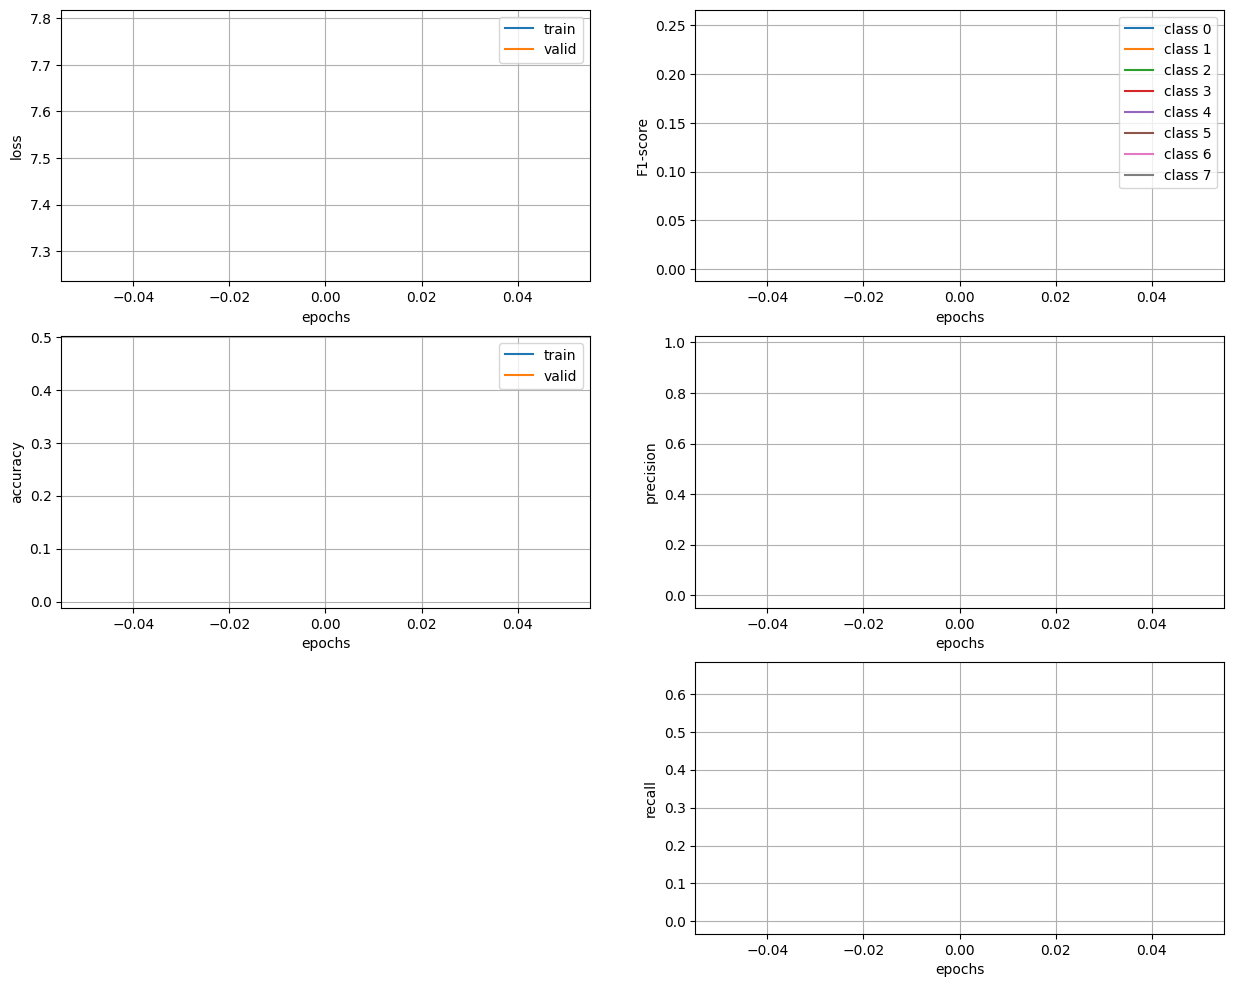

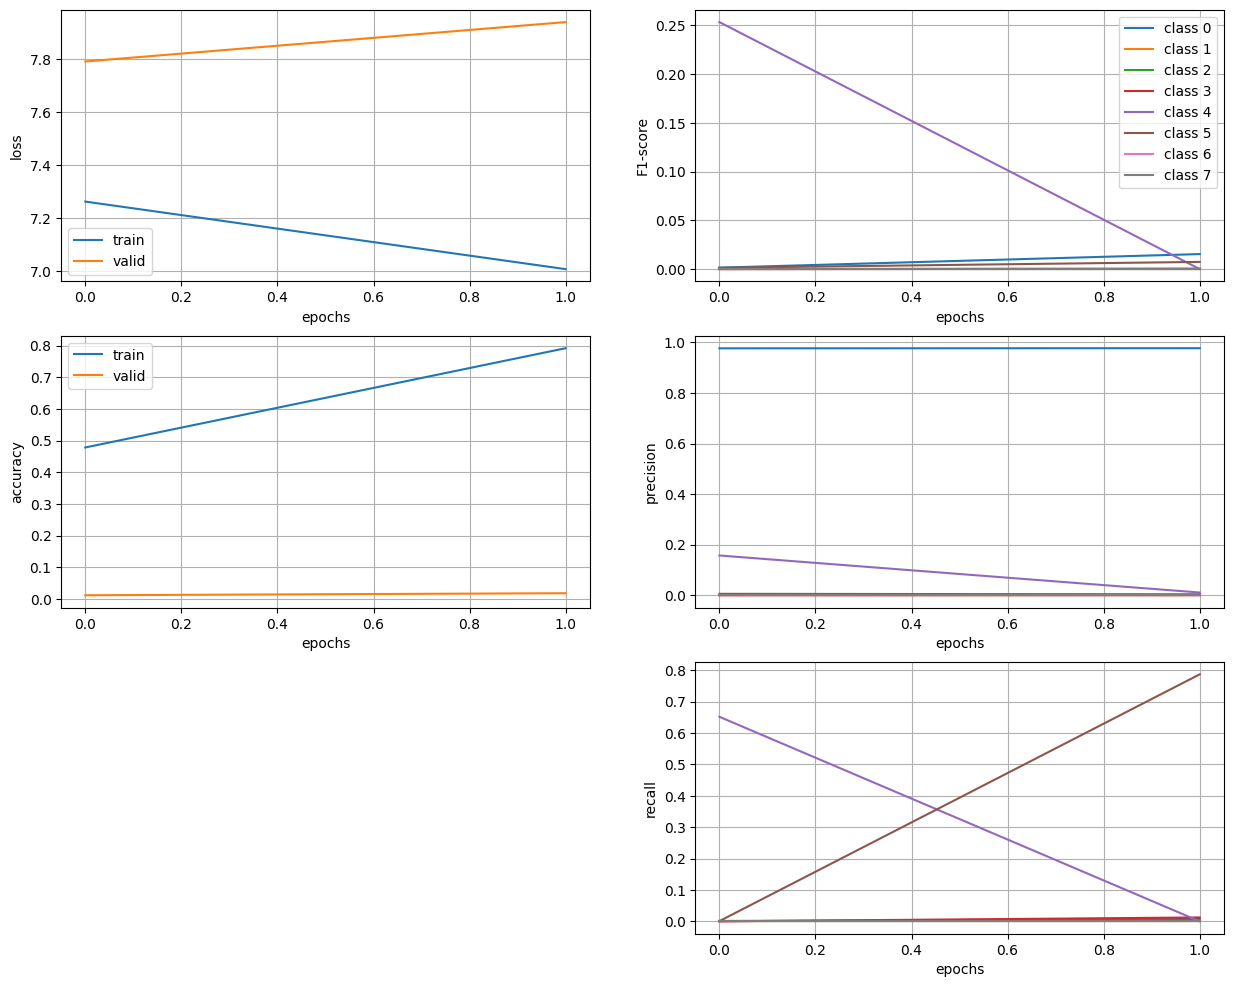

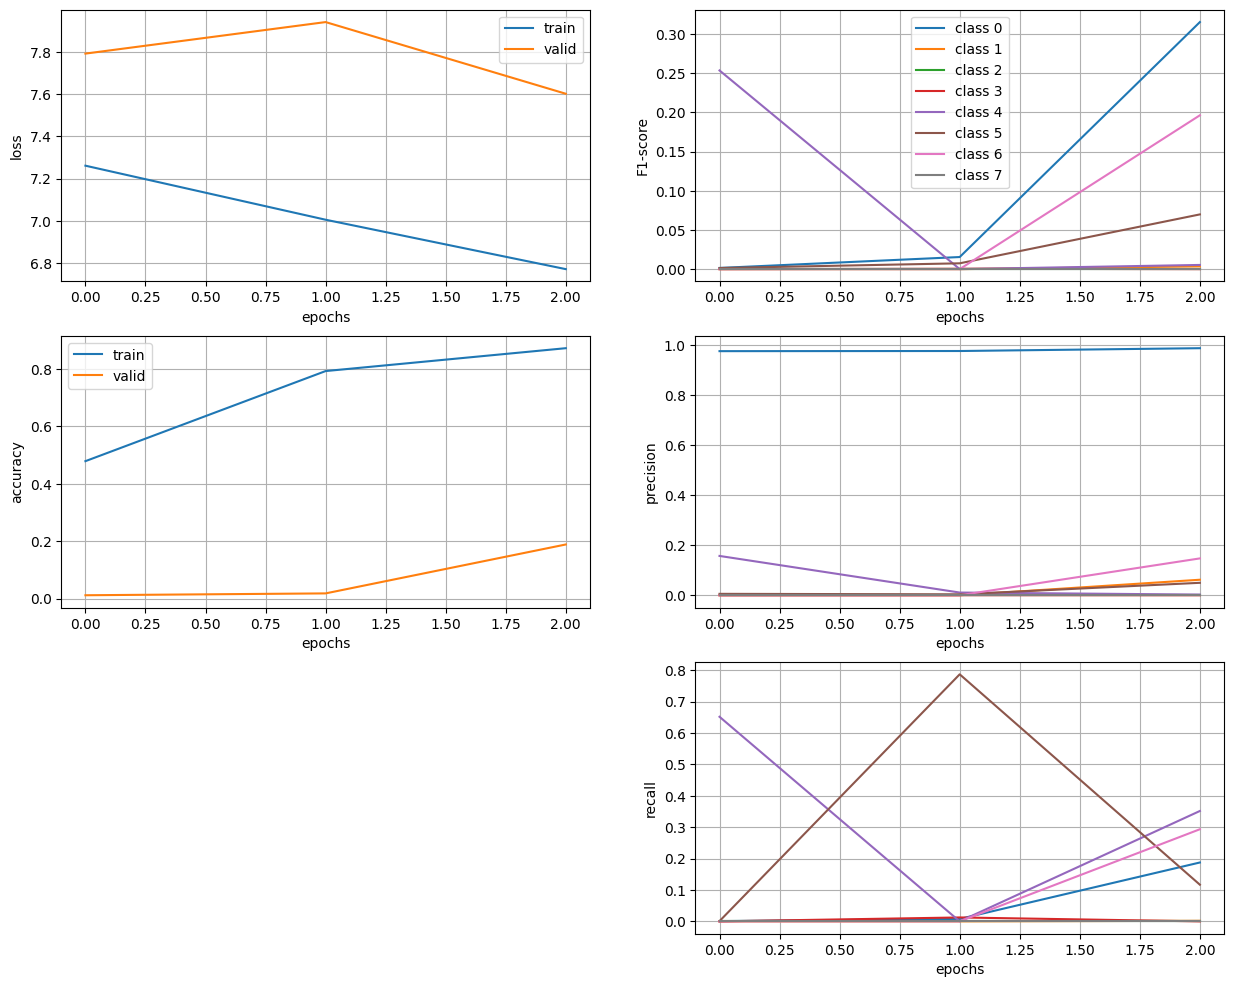

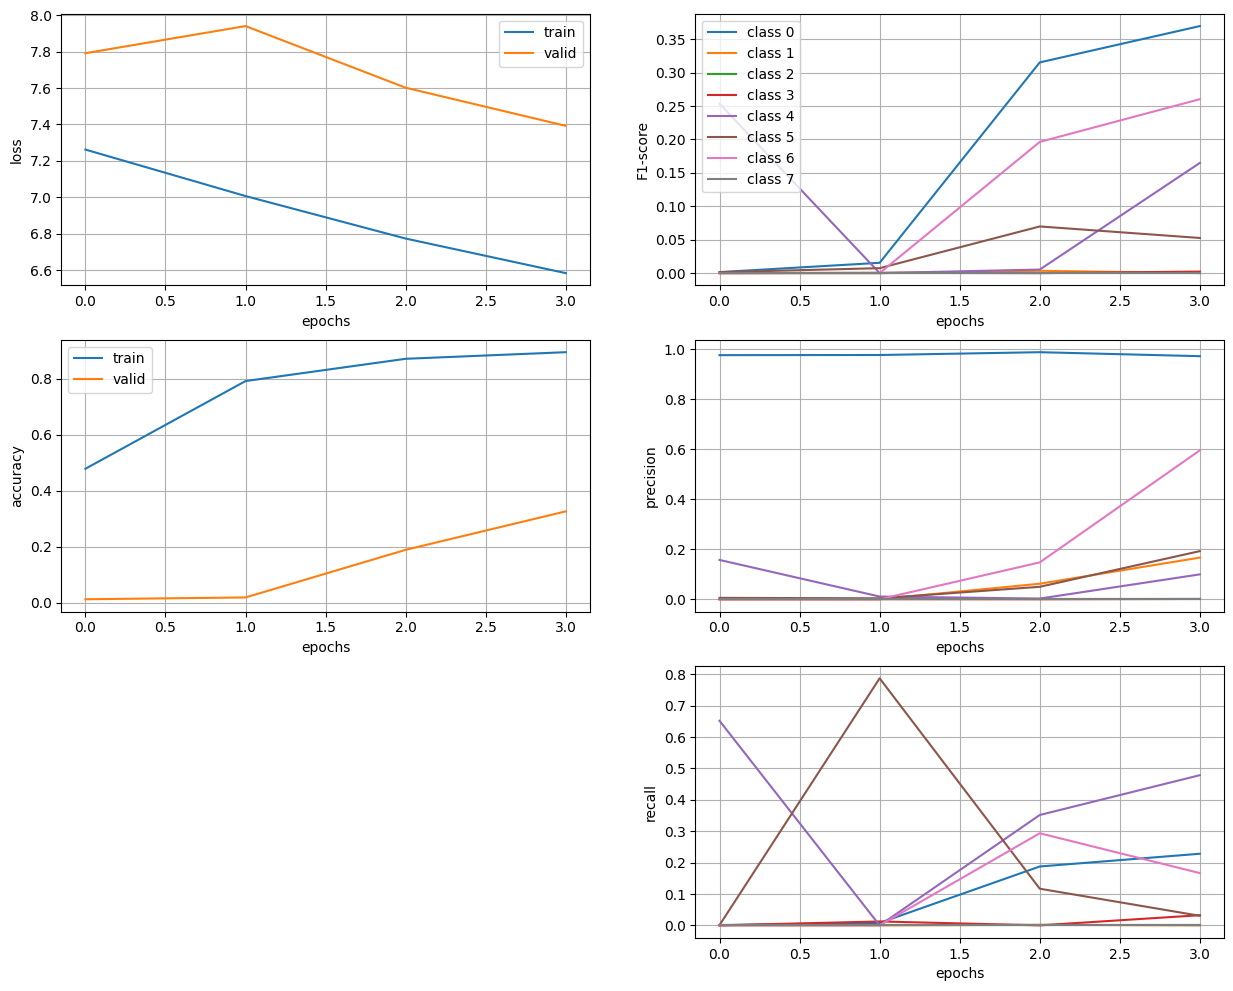

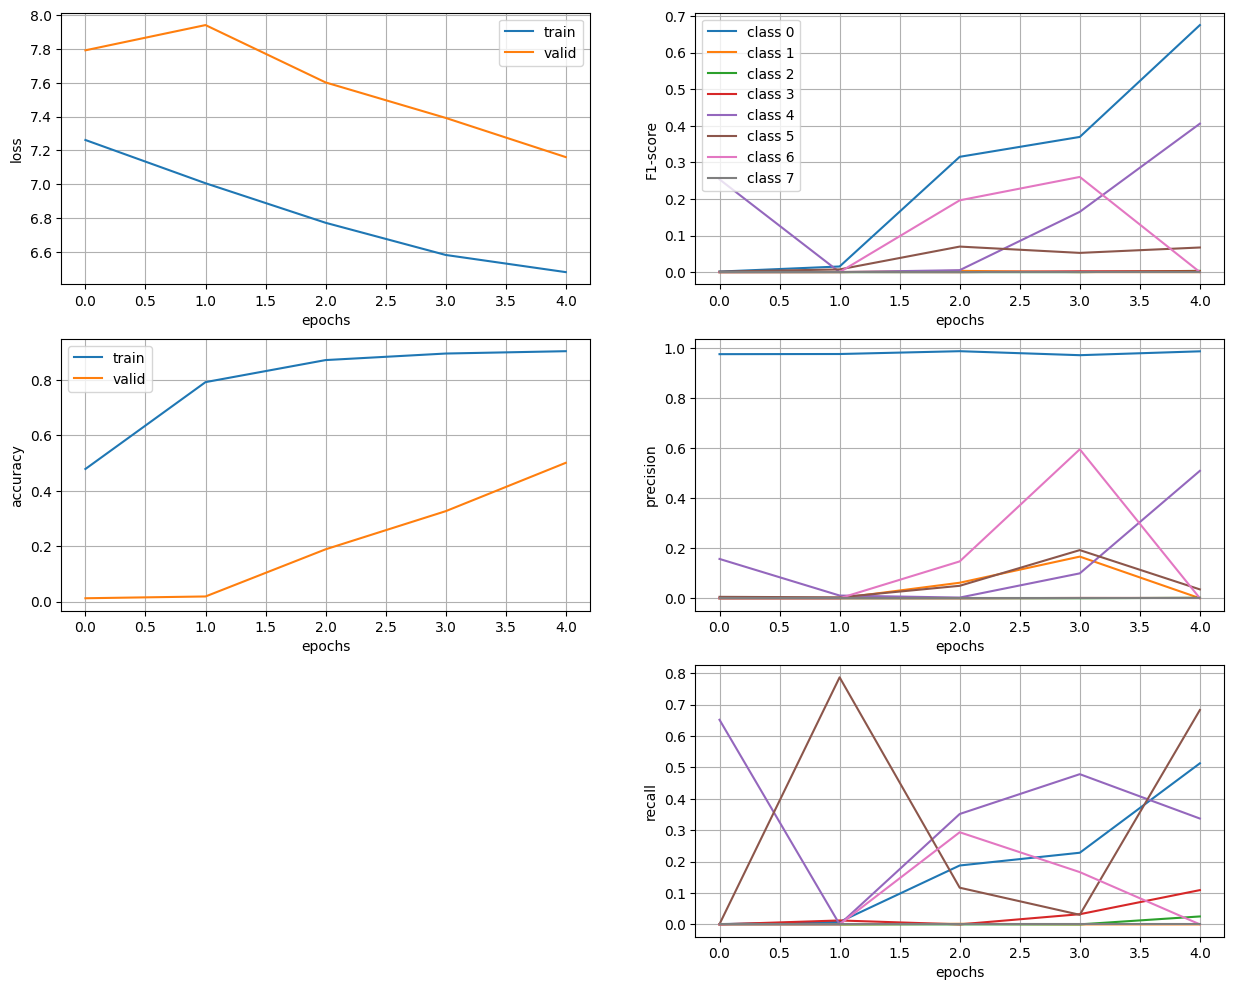

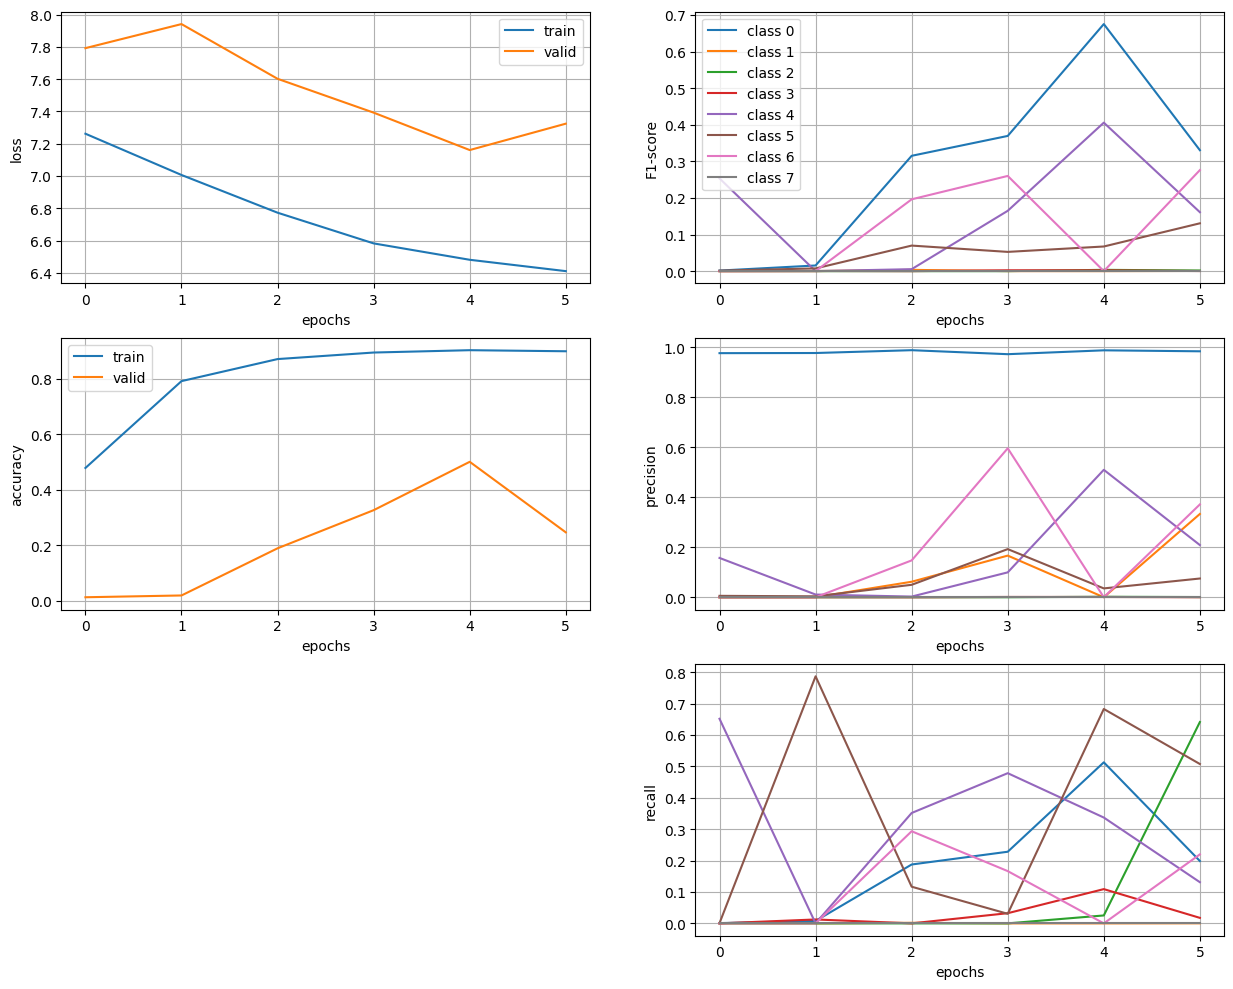

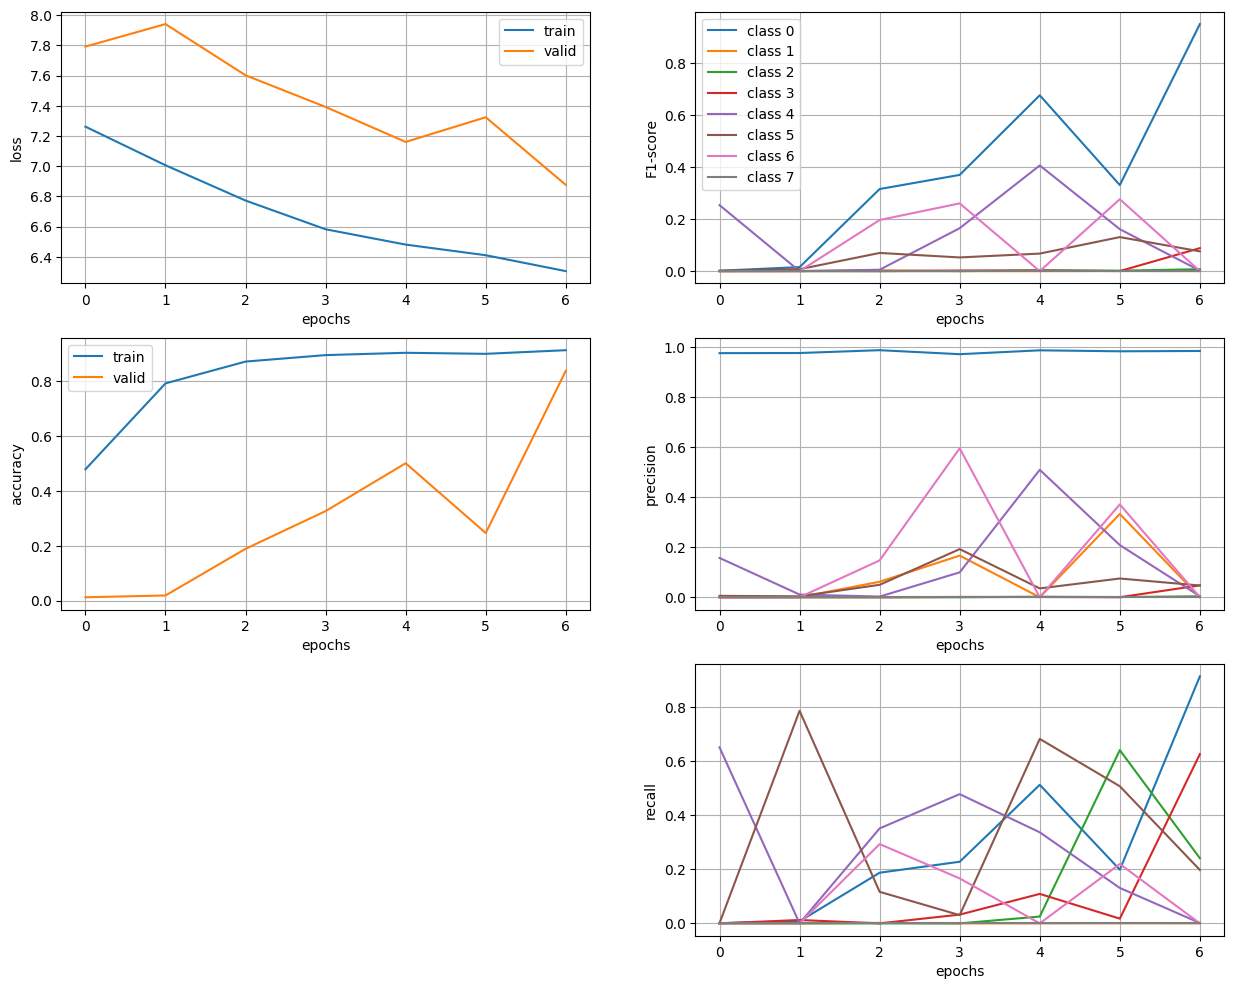

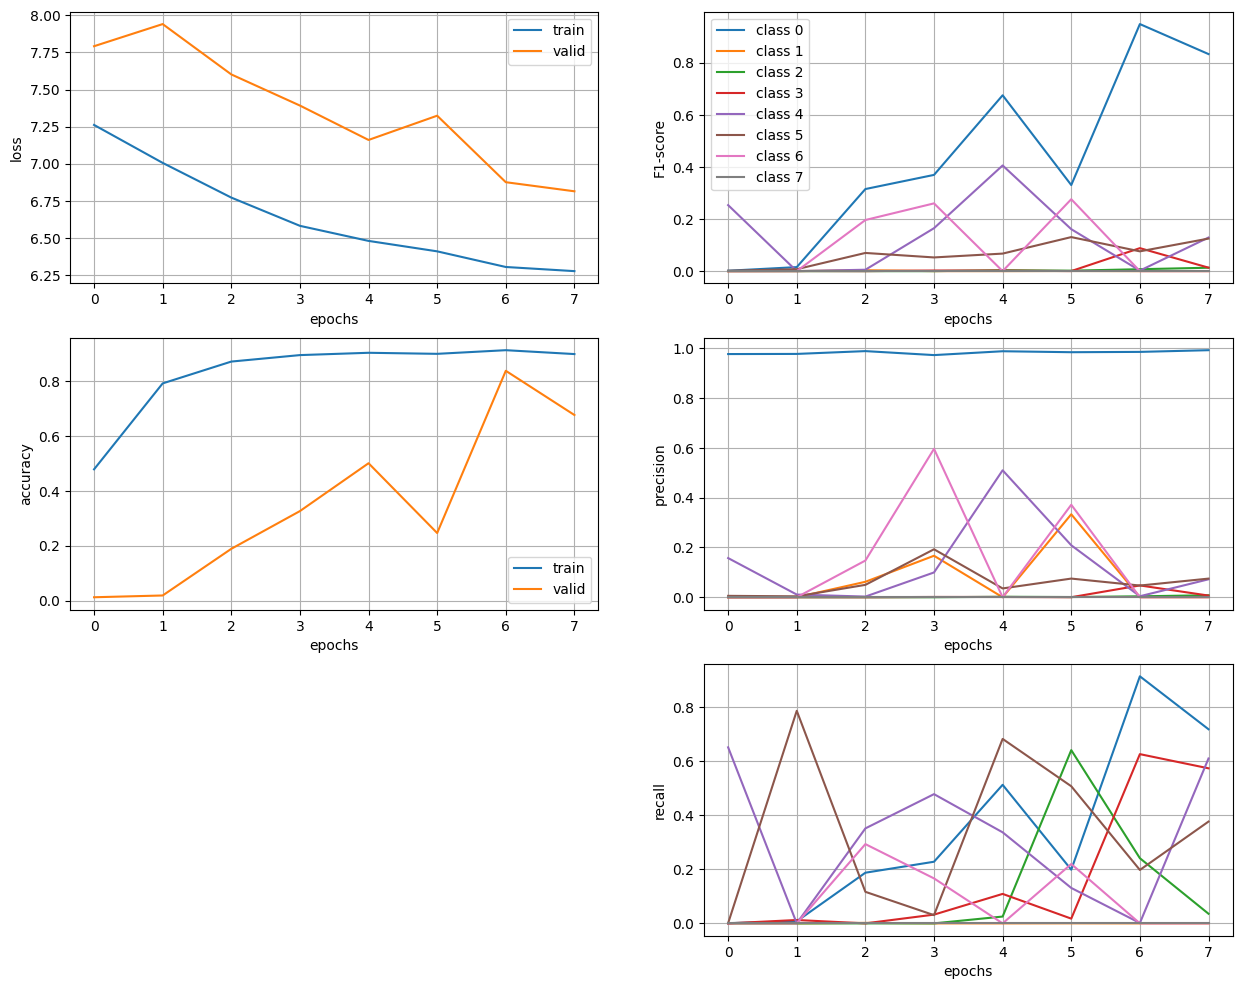

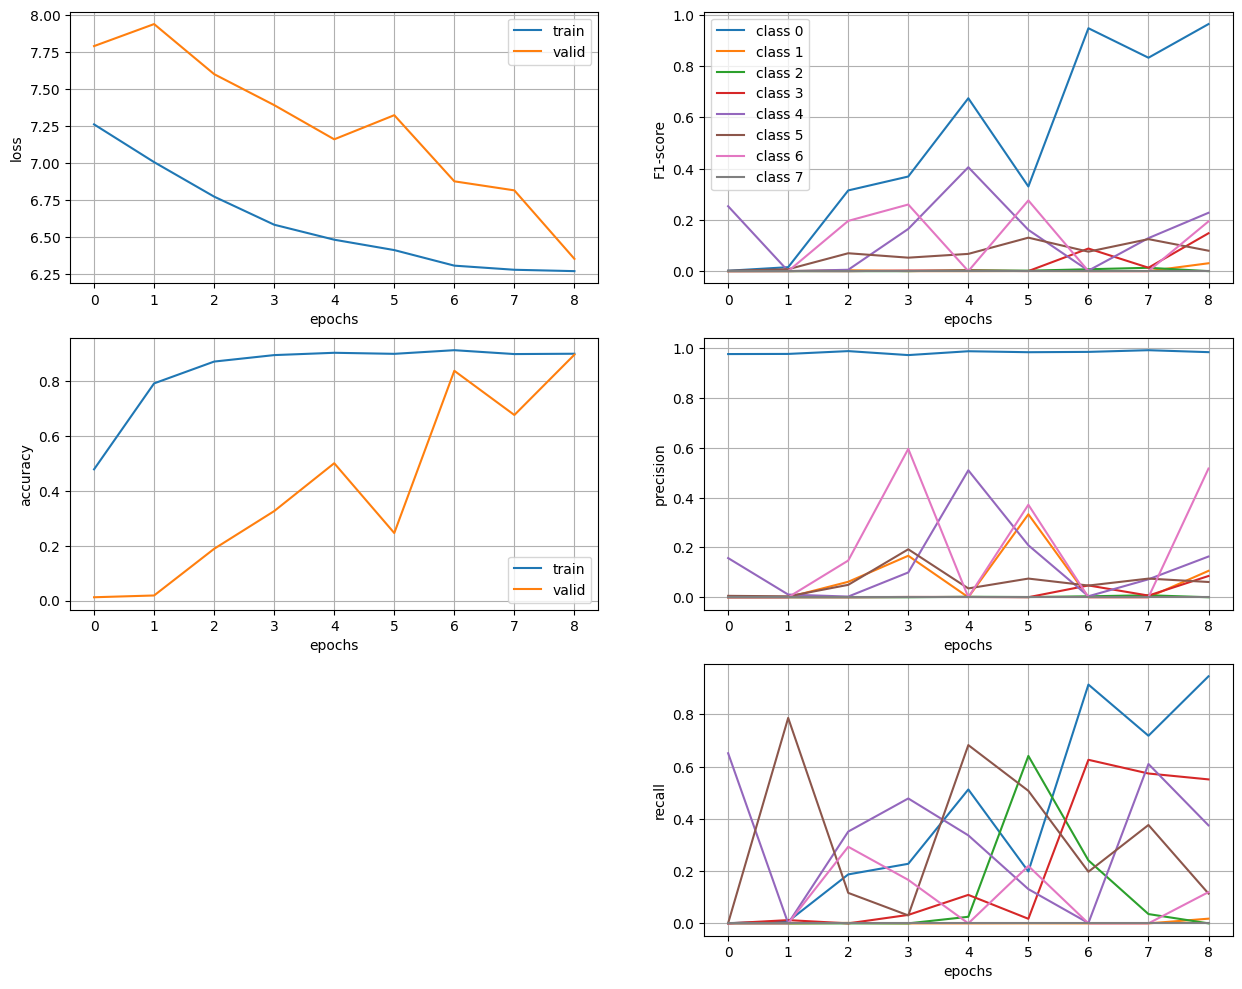

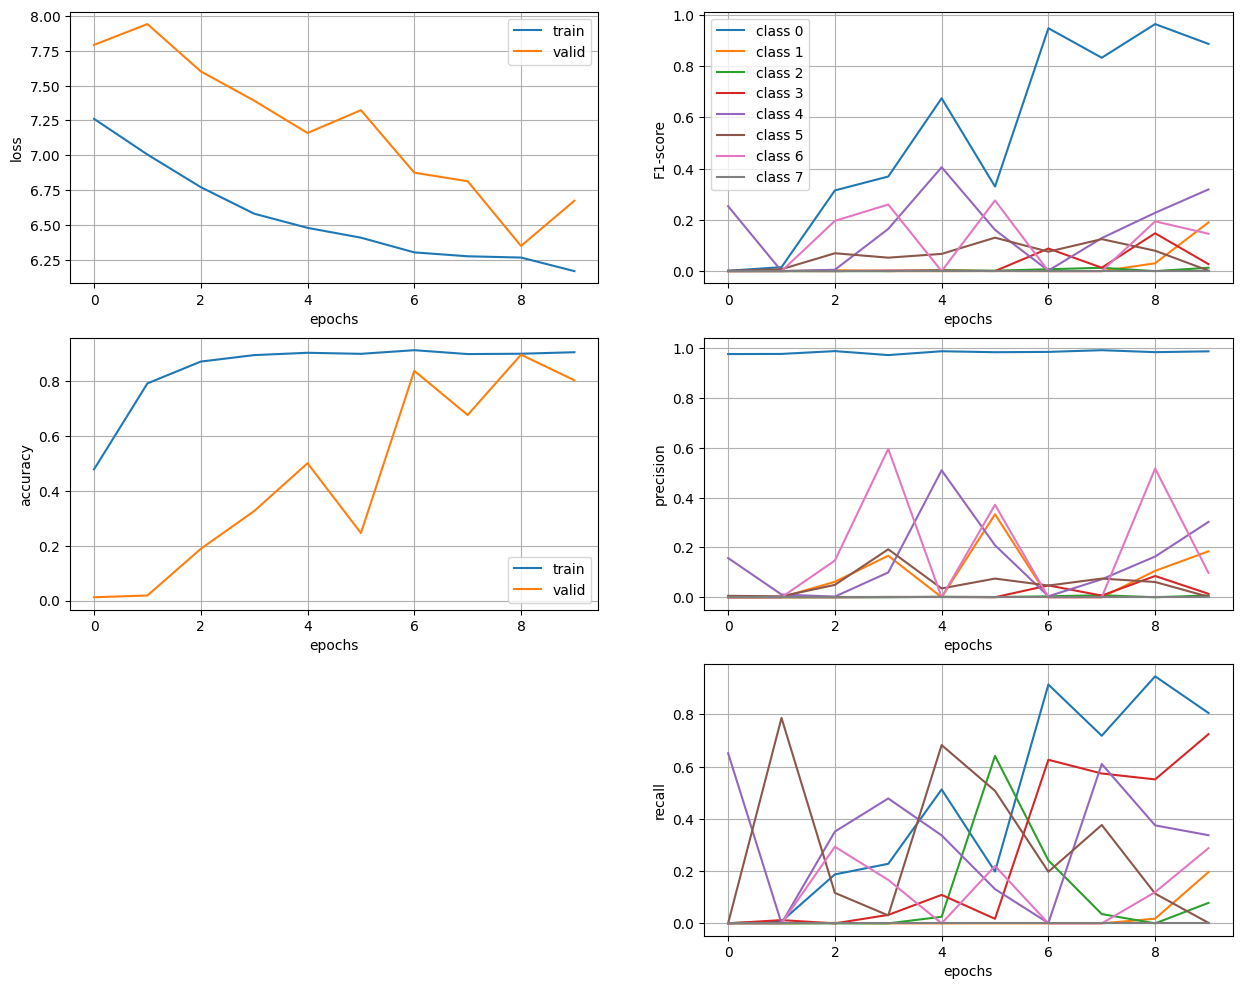

In [12]:
# Initiate the training of the DeepFindET 3D U-Net model.
step2.train_model(
    config,                 # Configuration file with various settings for the project.
    voxel_size,             # Voxel size used in the tomogram data.
    tomogram_algorithm,     # Reconstruction algorithm used for the tomograms (e.g., 'wbp').
    targets,                 # Target data for training the model.
    training_output_path,   # Path where the training outputs will be saved.
    model_name,             # Model architecture name ('res_unet').
    model_pre_weights,      # Pre-trained weights (None for training from scratch).
    n_class,                # Number of classes for segmentation (8 in this case).
    path_valid=None,        # Path to validation data (None means internal splitting may be used).
    dim_in=dim_in,          # Input dimension size in voxels.
    n_sub_epoch=2, #10,         # Number of epochs to train on tomograms prior to swapping to a new set of tomograms.
    sample_size=3,          # Number of tomograms to extract per epoch.
    batch_size=2, #10,          # Batch size used during training.
    epochs=10, #70,              # Total number of training epochs.
    steps_per_epoch=30, #150,    # Number of steps per epoch.
    n_valid=20,             # Number of validation samples.
    model_filters=[48, 64, 128],  # Filters in the convolutional layers at each level of the U-Net.
    model_dropout=0,        # Dropout rate (0 means no dropout applied).
    target_name="remotetargets",    # Name of the segmentation targets.
    target_user_id="deepfindET",  # User ID for the segmentation labels.
    target_session_id="0",    # Session ID associated with the labeling.
    valid_tomo_ids=None,    # List of tomogram IDs for validation.
    train_tomo_ids=None,     # List of tomogram IDs for training.
    class_weights=(('apo-ferritin', 1), ('beta-amylase', 0), ('beta-galactosidase', 2), ('ribosome', 1), ('thyroglobulin', 2), ('virus-like-particle', 1))
    # class_weights=(('apo-ferritin', 62400), ('beta-amylase', 4130), ('beta-galactosidase', 3080), ('ribosome', 1800), ('thyroglobulin', 10100), ('virus-like-particle', 8400))
)
# 10439:     # class_weights=(('membrane',1),('adp-mitochondrial',3000),('alkaline-phosphate',3000),('nucleosome',3000),('ribosome',750),('vault',500),('virus-like-capsid',750))


In [ ]:
from deepfindET.utils import core
import h5py, os

# Set the path to the training history file
history_path = os.path.join(training_output_path, 'net_train_history.h5')

# Convert the HDF5 file containing the training history into a dictionary format
# This allows easy access to the training metrics like loss, accuracy, etc., stored during training
history = core.convert_hdf5_to_dictionary(history_path)

# Plot the training history to visualize the learning process
# The plot_history function will generate curves for metrics such as training and validation loss, accuracy, etc.
core.plot_history(history, save_figure=False)
plt.show()